In [1]:
from matplotlib.pylab import *
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
π = pi

In [2]:
style.use(['dark_background', 'bmh'])
%matplotlib notebook

Car-trailer diagram (inverted image `car-trainer-k.png` available as well):
![car-trailer](car-trailer-w.png)

Car-trailer equation:
\begin{align}
\dot x &= s \cos \theta_0 \\
\dot y &= s \sin \theta_0 \\
\dot \theta_0 &= \frac{s}{L} \tan \phi \\
\dot \theta_1 &= \frac{s}{d_1} \sin(\theta_1 - \theta_0)
\end{align}
where $s$: signed speed, $\phi$: negative steering angle,

In [3]:
class Truck:
    def __init__(self, display=False):

        self.W = 1  # car and trailer width, for drawing only
        self.L = 1 * self.W  # car length
        self.d = 4 * self.L  # d_1
        self.s = -0.1  # speed
        self.display = display
        
        self.box = [0, 40, -10, 10]
        if self.display:
            self.f = figure(figsize=(10, 5), num='The truck backer-upper', facecolor='none')
            self.ax = self.f.add_axes([0.01, 0.01, 0.98, 0.98], facecolor='black')
            self.patches = list()
            
            self.ax.axis('equal')
            b = self.box
            self.ax.axis([b[0] - 1, b[1], b[2], b[3]])
            self.ax.set_xticks([], []); self.ax.set_yticks([], [])
            self.ax.axhline(); self.ax.axvline()

        self.reset()
    
    def reset(self, ϕ=0):
        self.ϕ = ϕ  # car initial steering angle
        
        # self.θ0 = deg2rad(30)  # car initial direction
        # self.θ1 = deg2rad(-30)  # trailer initial direction
        # self.x, self.y = 20, -5  # initial car coordinates
        
        self.θ0 = random() * 2 * π  # 0 <= ϑ₀ < 2π
        self.θ1 = (random() - 0.5) * π / 2 + self.θ0  # -π/4 <= ϑ₁ - ϑ₀ < π/4
        self.x = (random() * .75 + 0.25) * self.box[1]
        self.y = (random() - 0.5) * (self.box[3] - self.box[2])
        
        # If poorly initialise, then re-initialise
        if not self.valid():
            self.reset(ϕ)
        
        # Draw, if display is True
        if self.display: self.draw()
    
    def step(self, ϕ=0, dt=1):
        
        # Check for illegal conditions
        if self.is_jackknifed():
            print('The truck is jackknifed!')
            return
        
        if self.is_offscreen():
            print('The car or trailer is off screen')
            return
        
        self.ϕ = ϕ
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        # Perform state update
        self.x += s * cos(θ0) * dt
        self.y += s * sin(θ0) * dt
        self.θ0 += s / L * tan(ϕ) * dt
        self.θ1 += s / d * sin(θ0 - θ1) * dt
        
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def state(self):
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def set_state(self, x, y, θ0, θ1, ϕ):
        self.x = x
        self.y = y
        self.θ0 = θ0
        self.θ1 = θ1
        self.ϕ = ϕ
    
    def _get_atributes(self):
        return (
            self.x, self.y, self.W, self.L, self.d, self.s,
            self.θ0, self.θ1, self.ϕ
        )
    
    def _traler_xy(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return x - d * cos(θ1), y - d * sin(θ1)
        
    def is_jackknifed(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return abs(θ0 - θ1) * 180 / π > 90
    
    def is_offscreen(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        x1, y1 = x + 1.5 * L * cos(θ0), y + 1.5 * L * sin(θ0)
        x2, y2 = self._traler_xy()
        
        b = self.box
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )
        
    def valid(self):
        return not self.is_jackknifed() and not self.is_offscreen()
        
    def draw(self):
        if not self.display: return
        if self.patches: self.clear()
        self._draw_car()
        self._draw_trailer()
        self.f.canvas.draw()
            
    def clear(self):
        for p in self.patches:
            p.remove()
        self.patches = list()
        
    def _draw_car(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
        
        x1, y1 = x + L / 2 * cos(θ0), y + L / 2 * sin(θ0)
        bar = Line2D((x, x1), (y, y1), lw=5, color='C2', alpha=0.8)
        ax.add_line(bar)

        car = Rectangle(
            (x1, y1 - W / 2), L, W, 0, color='C2', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x1, y1, θ0 * 180 / π) +
            ax.transData
        )
        ax.add_patch(car)

        x2, y2 = x1 + L / 2 ** 0.5 * cos(θ0 + π / 4), y1 + L / 2 ** 0.5 * sin(θ0 + π / 4)
        left_wheel = Line2D(
            (x2 - L / 4 * cos(θ0 + ϕ), x2 + L / 4 * cos(θ0 + ϕ)),
            (y2 - L / 4 * sin(θ0 + ϕ), y2 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(left_wheel)

        x3, y3 = x1 + L / 2 ** 0.5 * cos(π / 4 - θ0), y1 - L / 2 ** 0.5 * sin(π / 4 - θ0)
        right_wheel = Line2D(
            (x3 - L / 4 * cos(θ0 + ϕ), x3 + L / 4 * cos(θ0 + ϕ)),
            (y3 - L / 4 * sin(θ0 + ϕ), y3 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(right_wheel)
        
        self.patches += [car, bar, left_wheel, right_wheel]
        
    def _draw_trailer(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
            
        x, y = x - d * cos(θ1), y - d * sin(θ1) - W / 2
        trailer = Rectangle(
            (x, y), d, W, 0, color='C0', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x, y + W/2, θ1 * 180 / π) +
            ax.transData
        )
        ax.add_patch(trailer)
        
        self.patches += [trailer]

<IPython.core.display.Javascript object>


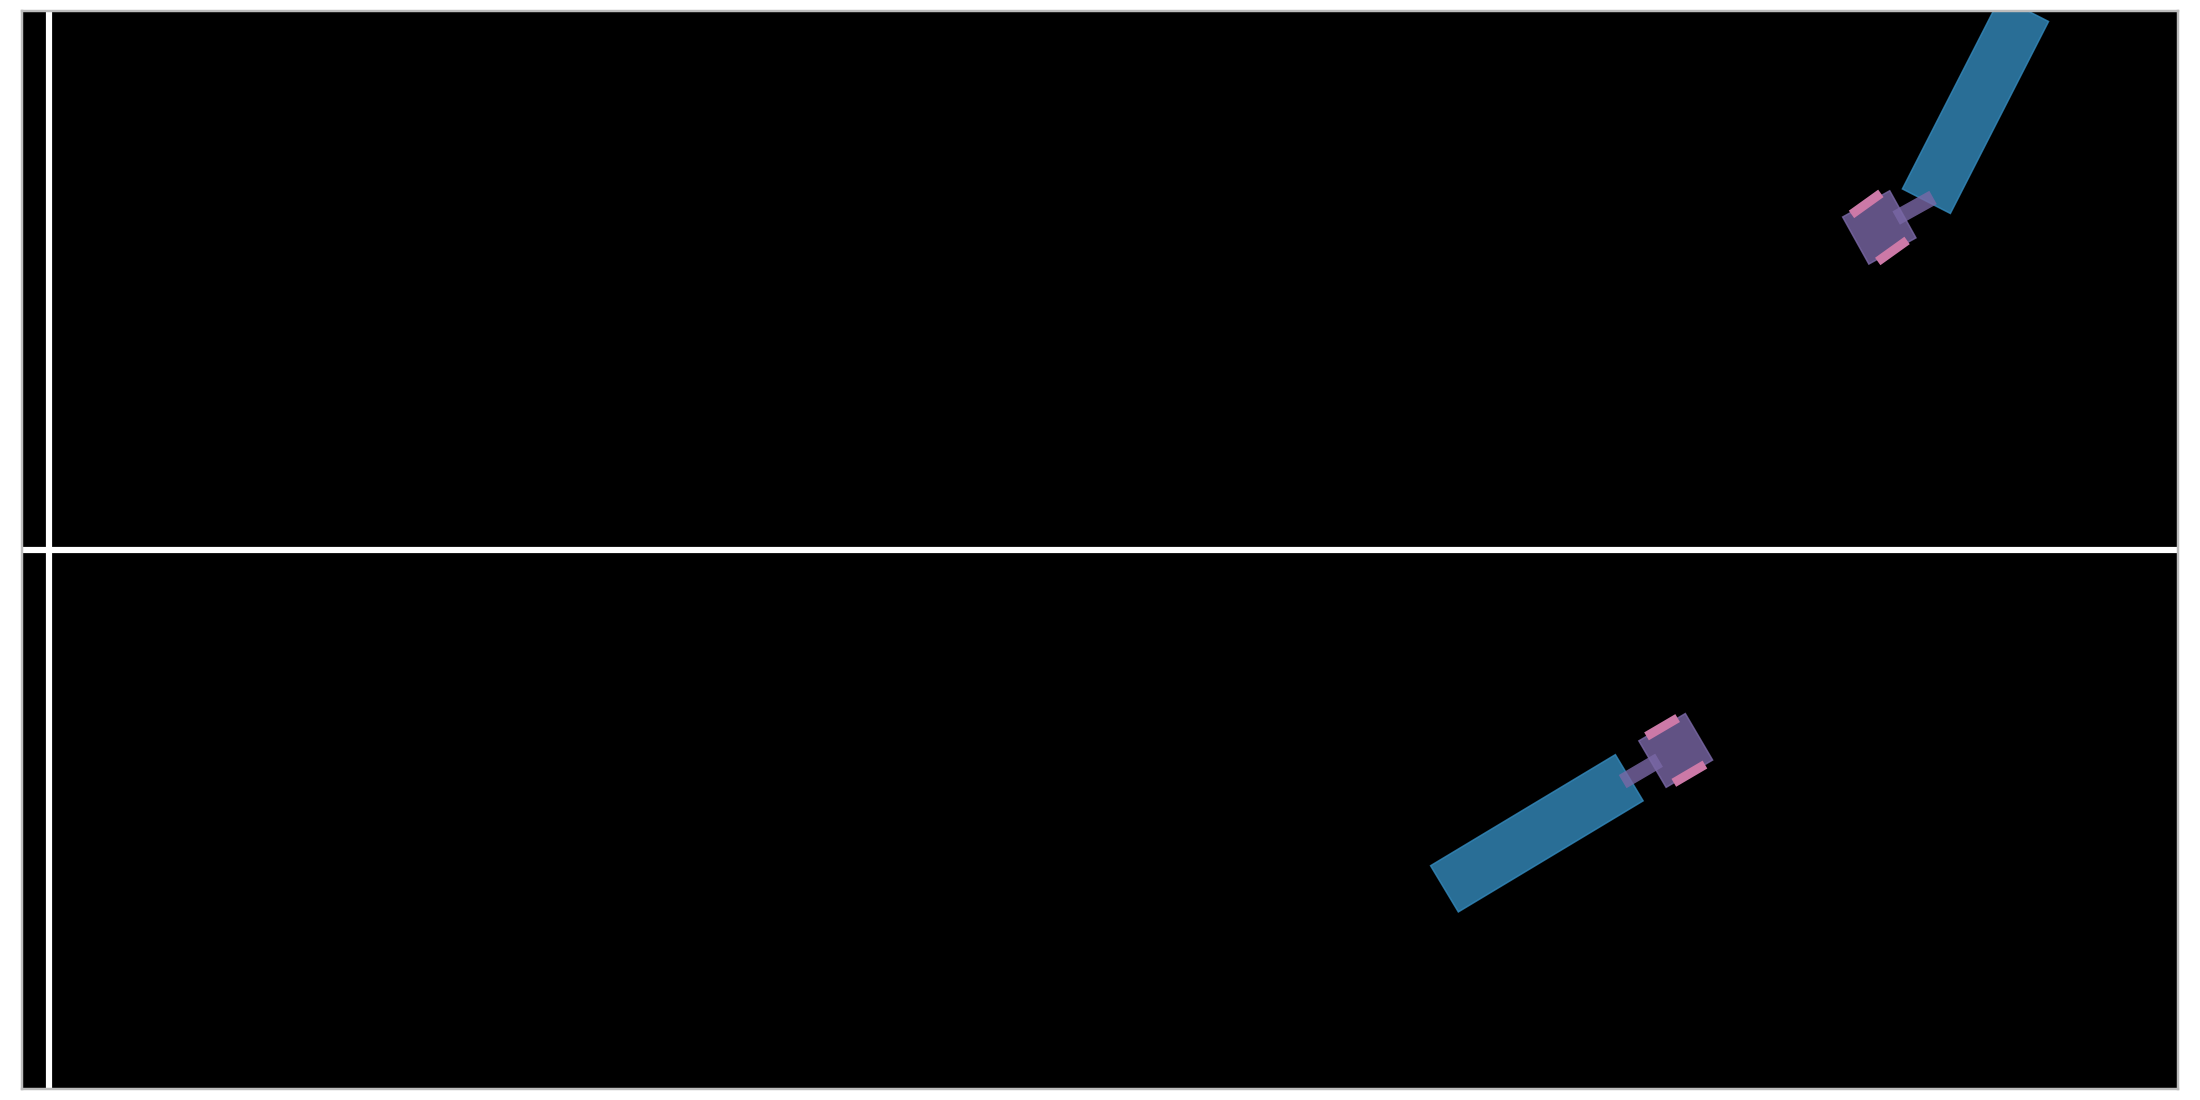

In [5]:
display_truck = Truck(display=True)

In [14]:
ϕ = deg2rad(-35)  # positive left, negative right
display_truck.step(ϕ)
display_truck.draw()

In [15]:
display_truck.reset()

In [16]:
import torch
import torch.nn as nn
from torch.optim import SGD
from tqdm import tqdm

In [17]:
# Build expert data set

episodes = 100
inputs = list()
outputs = list()
truck = Truck(); episodes = 10_000  # uncooment for creating the data set

for episode in tqdm(range(episodes)):
    
    truck.reset()
    
    while truck.valid():
        initial_state = truck.state()
        ϕ = (random() - 0.5) * π / 2
        inputs.append((ϕ, *initial_state))
        outputs.append(truck.step(ϕ))
        truck.draw()

100%|██████████| 10000/10000 [00:22<00:00, 435.85it/s]


In [18]:
len(inputs), len(outputs)

(599043, 599043)

In [19]:
state_size = 6
steering_size = 1
hidden_units_e = 45

emulator = nn.Sequential(
    nn.Linear(steering_size + state_size, hidden_units_e),
    nn.ReLU(),
    nn.Linear(hidden_units_e, state_size)
)

optimiser_e = SGD(emulator.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [20]:
tensor_inputs = torch.Tensor(inputs)
tensor_outputs = torch.Tensor(outputs)

In [21]:
mean = tensor_inputs.mean(0)
std = tensor_inputs.std(0)
tensor_inputs = (tensor_inputs - mean) / std
tensor_outputs = (tensor_outputs - mean[1:]) / std[1:]

In [22]:
# Split the data into 80:20 for test:train.
test_size = int(len(tensor_inputs) * 0.8)
print(len(tensor_inputs), test_size)

train_inputs = tensor_inputs[:test_size]
train_outputs = tensor_outputs[:test_size]
test_inputs = tensor_inputs[test_size:]
test_outputs = tensor_outputs[test_size:]

599043 479234


In [29]:
# Train... BUG! Can you spot it?
# What is one of the main assumptions for training a net?

cnt = 0
avg_loss = 0
for epoch in range(1):
    for i in torch.randperm(len(train_inputs)):
        ϕ_state = train_inputs[i]
        next_state_prediction = emulator(ϕ_state)

        next_state = train_outputs[i]
        loss = criterion(next_state_prediction, next_state)
        avg_loss += loss.item()
        optimiser_e.zero_grad()
        loss.backward()
        optimiser_e.step()

        if cnt == 0 or (cnt + 1) % 10_000 == 0:
            print(f'{cnt + 1:4d} / {len(train_inputs)}, {avg_loss/10_000:.10f}')
            avg_loss = 0
        cnt += 1

   1 / 479234, 0.0000000078
10000 / 479234, 0.0003483736
20000 / 479234, 0.0003390886
30000 / 479234, 0.0003370836
40000 / 479234, 0.0003406425
50000 / 479234, 0.0003342990
60000 / 479234, 0.0003271451
70000 / 479234, 0.0003275913
80000 / 479234, 0.0003231564
90000 / 479234, 0.0003218105
100000 / 479234, 0.0003223896
110000 / 479234, 0.0003261700
120000 / 479234, 0.0003143065
130000 / 479234, 0.0003151940
140000 / 479234, 0.0003082754
150000 / 479234, 0.0003057796
160000 / 479234, 0.0003028891
170000 / 479234, 0.0002969970
180000 / 479234, 0.0003043954
190000 / 479234, 0.0002985944
200000 / 479234, 0.0002952815
210000 / 479234, 0.0002921473
220000 / 479234, 0.0002921412
230000 / 479234, 0.0002828433
240000 / 479234, 0.0002821384
250000 / 479234, 0.0002793105
260000 / 479234, 0.0002821161
270000 / 479234, 0.0002756331
280000 / 479234, 0.0002771103
290000 / 479234, 0.0002728128
300000 / 479234, 0.0002723922
310000 / 479234, 0.0002708781
320000 / 479234, 0.0002659589
330000 / 479234, 0.00

In [30]:
# Test
total_loss = 0
with torch.no_grad():
    for idx, ϕ_state in enumerate(test_inputs):
        next_state_prediction = emulator(ϕ_state)

        next_state = test_outputs[idx]
        total_loss += criterion(next_state_prediction, next_state).item()

    
print(f'Test loss: {total_loss/len(test_inputs):.10f}')

Test loss: 0.0002441985


In [38]:
hidden_units_c = 25

controller = nn.Sequential(
    nn.Linear(state_size, hidden_units_c),
    nn.Tanh(),
    nn.Linear(hidden_units_c, steering_size)
)

optimiser_c = SGD(controller.parameters(), lr=0.0001)

In [39]:
controller.train()
emulator.eval()
truck = Truck()
avg_loss = 0
avg_steps = 0
for epoch in range(10000):
    truck.reset() # selecting a random truck position, we want to park it to the dock
    target_state = torch.tensor([truck.d, 0, 0, 0, 0, 0], dtype=torch.float)
#     target_state = (target_state - mean[1:]) / std[1:]
    curr_state = torch.tensor(truck.state())
    curr_state = (curr_state - mean[1:]) / std[1:]
    cnt = 0
    prev_loss = None
    
    loss = None
    optimiser_c.zero_grad()
    while truck.valid():
        
        
        curr_state = torch.tensor([*curr_state])
        
        ϕ_pred = controller(curr_state)
        
        
        pred_state = emulator(torch.tensor([ϕ_pred, *curr_state]))
        
        loss = criterion( (pred_state[4:]*std[5:])+mean[5:], target_state[4:])
        
        avg_loss = loss.item()
        
        # accumulating gradient
        loss.backward()
        
        curr_state = pred_state
        
        ϕ = (ϕ_pred[0]*std[0]) + mean[0]
        state = (pred_state*std[1:]) + mean[1:]
        
        ϕ = ϕ.detach().numpy()
        state = state.detach().numpy()
        
        truck.set_state(state[0], state[1], state[2], state[5], ϕ)
        
        curr_state = pred_state
        
        if prev_loss is not None and abs(loss.item()-prev_loss) < 0.001:
            break
        prev_loss = loss.item()
        truck.draw()
        cnt += 1
        avg_steps += 1
    optimiser_c.step()
    if epoch%100 == 0:
        print("epoch: {}, loss: {} Average steps: {}".format(epoch, avg_loss/100, avg_steps/100))
        avg_loss = 0
        avg_steps = 0

epoch: 0, loss: 0.0671834945678711 Average steps: 0.23
epoch: 100, loss: 0.5803186798095703 Average steps: 47.6
epoch: 200, loss: 0.21224056243896483 Average steps: 43.89
epoch: 300, loss: 0.4981222915649414 Average steps: 39.43
epoch: 400, loss: 0.22250499725341796 Average steps: 46.13
epoch: 500, loss: 0.42479061126708983 Average steps: 41.79
epoch: 600, loss: 0.03139426946640014 Average steps: 46.24
epoch: 700, loss: 0.0002359328232705593 Average steps: 46.25
epoch: 800, loss: 0.042625112533569334 Average steps: 42.55
epoch: 900, loss: 0.1814879608154297 Average steps: 38.47
epoch: 1000, loss: 0.23977304458618165 Average steps: 46.13
epoch: 1100, loss: 0.10606667518615723 Average steps: 41.17
epoch: 1200, loss: 0.25962799072265624 Average steps: 47.7
epoch: 1300, loss: 0.24807676315307617 Average steps: 46.27
epoch: 1400, loss: 0.24407833099365234 Average steps: 38.91
epoch: 1500, loss: 0.09196634292602539 Average steps: 41.32
epoch: 1600, loss: 0.2163960838317871 Average steps: 45.

In [40]:
# Test the controller
# It should smoothly park the truck
# Using the emulator ouput to go the next state of truck
target_state = torch.tensor([truck.d, 0, 0, 0, 0, 0], dtype=torch.float)
truck = Truck(display=True)
controller.eval()
emulator.eval()
prev_loss = None # using for stopping condition, if stuck somewhere else other than target.
for simulation in range(100):
    truck.reset()
    truck.draw()
    curr_state = torch.tensor(truck.state())
    curr_state = (curr_state - mean[1:]) / std[1:]
    cnt = 0
    while truck.valid():
        
        ϕ_pred = controller(torch.tensor([*curr_state]))
        pred_state = emulator(torch.tensor([ϕ_pred, *curr_state]))
        
        loss = criterion( (pred_state[4:]*std[5:])+mean[5:], target_state[4:])
    
        if prev_loss is not None and abs(loss.item()-prev_loss) < 0.001:
            break
        prev_loss = loss.item()    
        
        ϕ = (ϕ_pred[0]*std[0]) + mean[0]
        state = (pred_state*std[1:]) + mean[1:]
        
        ϕ = ϕ.detach().numpy()
        state = state.detach().numpy()
        
        truck.set_state(state[0], state[1], state[2], state[5], ϕ)
        truck.draw()
        cnt += 1
        curr_state = pred_state

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


KeyboardInterrupt: 

In [41]:
# Test the controller
# It should smoothly park the truck
# This is not using the emulator
controller.eval()
emulator.eval()

for simulation in range(20):
    truck.reset()
    truck.draw()
    while truck.valid():
        curr_state = torch.tensor(truck.state())
        curr_state = (curr_state - mean[1:]) / std[1:]
        ϕ_pred = controller(torch.tensor([*curr_state]))
        ϕ = (ϕ_pred[0]*std[0]) + mean[0]
        truck.step(ϕ.detach().numpy())
        truck.draw()